# Finite element solver for an elastic rod

We create in this notebook a simple finite element solver for a linear elastic rod using continuous, piecewise linear finite elements.

We will use NumPy to perform the simulations, and Matplotlib to visualise the results, so we first import the NumPy and Matplotlib modules:

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## A first solver

### Elastic parameters

For our elastic rod, we define the Young's modulus $E$ and the cross-sectional area $A$. Both are assumed constant.

In [2]:
E = 100.0
A = 1.0

### Distributed load

We now define the distributed load $f$. We will use a function that takes the coordinate $x$ as an argument so we possibly define loading terms that vary with position.

In [3]:
def distributed_load(x):
    return 1.0

### Create a mesh

We will create a mesh of length $L$ with a prescribed number of cells (elements) $n_{\text{cells}}$. For linear elements, the number of nodes $n_{\text{nodes}}$ is equal to $n_{\text{cells}} + 1$.

In [4]:
L = 10.0
n_cells = 30
n_nodes = n_cells + 1

To create a mesh from 0 to $L$ with equal size cells (elements) we will use the NumPy function `linspace` to generate an array of equally spaced points on the interval $[0, L]$.

In [5]:
mesh = np.linspace(0.0, L, n_nodes)

Matplotlib can be used to visualise the mesh:

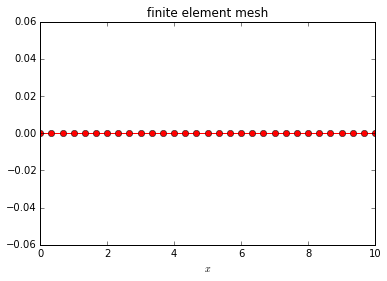

In [6]:
plt.xlabel('$x$')
plt.title('finite element mesh')
plt.plot(mesh, np.zeros(len(mesh)), 'ro-');

### A simple finite element solver

We have already defined our domain (the mesh) and the constitutive parameters ($E$ and $A$). We now need to build the global stiffness matrix ${\bf{K}}$ and the global right-hand side vector $\bf{b}$, after which we can solve $\bf{K} \bf{a} = \bf{b}$ to get the nodal degrees-of-freedom $\bf{a}$. 

#### Create stiffness matrix $\bf{K}$

We create the global stiffness matrix by computing the element matrix $\bf{k}_{e}$ (which is constant since $A$, $E$ and the cell size are constant in our case), and then looping over all cells and adding their contribution to the global matrix.

##### Element stiffness matrix $\bf{k}_{e}$

The element stiffness matrix for a linear element of length $l$ and constant $AE$ is

$$
{\bf k}_{e} 
= \frac{EA}{l}
\begin{bmatrix}
1 & -1 \\ -1 & 1    
\end{bmatrix}
$$

Our mesh has constant cells size, so we can compute $\bf{k}_{e}$ just once:

In [7]:
l = L/n_cells
k_e = (E*A/l)*np.array([[1, -1], [-1, 1]])
print(k_e)

[[ 300. -300.]
 [-300.  300.]]


##### Assemble global stiffness matrix

To build the global stiffness matrix $\bf{K}$, we first create an empty $n_{\text{nodes}} \times n_{\text{nodes}}$ matrix: 

In [9]:
K = np.zeros((n_nodes, n_nodes))

Next, we loop over each cell and add the cell contribution $\bf{k}_{e}$ to the the global matrix $\bf{K}$. This is known as *assembly*. 

In [10]:
for element in range(n_cells):
    K[element:element + 2, element:element + 2] += k_e

#### Create RHS vector $\bf{b}$

We create the global RHS vector $\bf{b}$ by computing the cell RHS $\bf{b}_{e}$ cell-by-cell, and adding this to the global RHS vector. We allow the distributed load $f$ to vary with position, which is why we cannot compute it just once. For simplicity we will integral the local RHS use the midpoint rule. This is exact of $f$ is constant, and is otherwise approximate.

We first crate an empty global RHS vector: 

In [11]:
b = np.zeros(n_nodes)

We now loop over each cell and compute $\int_{x_{i}}^{x_{i+1}} N_{1} f dx$ and $\int_{x_{i}}^{x_{i+1}} N_{2} f dx$ for each cell, and add the contribution to the global RHS vector: 

In [12]:
for element in range(n_cells):

    # Get cell length and midpoint
    l     = mesh[element + 1] - mesh[element]   
    x_mid = (mesh[element + 1] + mesh[element])/2.0
    
    # Evaluate loading term
    f = distributed_load(x_mid)

    # Compute and add RHS contributions
    b[element:element + 2] += 0.5*l*f

#### Apply Dirichet (displacement) boundary condition

We're almost to solve a finite element problem, but we would get into trouble if we tried to solve $\boldsymbol{K} \boldsymbol{a} = \boldsymbol{b}$ using the above stiffness matrix because it is singular (you can verify this be computing the determinate with `np.linalg.det(K)`). The system is singular because we have not applied a Dirichlet boundary condition, hence there is a rigid body translation mode in th system.

We impose the boundary condition $u = 0$ and $x=0$ by zeroing the first row and column of the matrix, placing a one on the first diagonal entry and setting the first entry on the RHS to zero. It should be clear algebraically that this will ensure that the first degree of freedom is equation to zero when we solve the system.

In [13]:
# Zero first row and first column
K[0, :] = 0.0
K[:, 0] = 0.0

# Place one on the diagonoal of K and zero in the first entry on the RHS
K[0, 0] = 1.0
b[0] = 0.0

#### Solve system of equations

We can now solve the finite element system $\boldsymbol{K}$:

In [14]:
u = np.linalg.solve(K, b)

#### Visualising the solution

We now plot the solution:

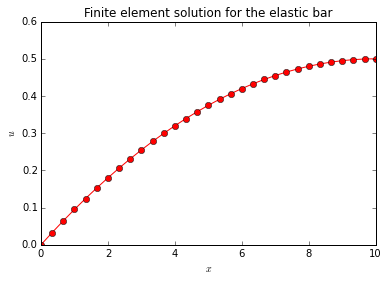

In [15]:
plt.xlabel('$x$')
plt.ylabel('$u$')
plt.title('Finite element solution for the elastic bar')
plt.plot(mesh, u, 'ro-');

## A more programatic approach

We now present a finite element solver that is very similar the one above, but we now provide a programming interface so we can reuse a function to explore different loading functions and different levels of refinement of the mesh.

In [18]:
def solver(L, f, n_cells):
    "A simple finite element solver for a 1D bar"    

    # Crarte mesh and compute cell size
    n_nodes = n_cells + 1
    mesh = np.linspace(0.0, L, n_nodes)
    l = L/n_cells

    # Compute local stiffness matrix
    k_e = (E*A/l)*np.array([[1, -1], [-1, 1]])
    
    # Assemble global stiffnes matrix
    K = np.zeros((n_nodes, n_nodes))
    for element in range(n_cells):
        K[element:element + 2, element:element + 2] += k_e
        
    # Two-point Gauss quadrature points on the interval (-1, 1)
    x_quadrature = ((-1.0/np.sqrt(3.0), 1.0), (1.0/np.sqrt(3.0), 1.0))
    
    # Assemble RHS using two-point Gauss quadrature
    b = np.zeros(n_nodes)    
    for element in range(n_cells):

        # Get cell midpoint
        x_mid = (mesh[element + 1] + mesh[element])/2.0    

        # Loop over quadrature points
        for zeta, weight in x_quadrature:        
            # Compute coordinate of point 
            x = x_mid + zeta*l/2.0

            # Evaluate loading term
            f_load = f(x)

            # Quadrature weight
            w = weight*(l/2.0)
            
            # Compute RHS contributions
            N = 0.5 - zeta/2.0 
            b[element] += w*N*f_load 

            N = 0.5 + zeta/2.0 
            b[element + 1] += w*N*f_load

    # Apply boundary condition
    K[0, :], K[:, 0], K[0, 0] = 0.0, 0.0, 1.0
    b[0] = 0.0
    
    return np.linalg.solve(K, b), mesh

We want to see how the solution changes with mesh refinement for some loading function. To set $f = \sin(x)$, we create a function:

In [19]:
def f_sine(x):
    return np.sin(x)

We now compute solutions for four increasingly fine meshes and store the mesh and the computed displacement field. We pass the domain length (`L`), the function for computing the loading (`f_sine`) and the number cells in the mesh (`n`):

In [20]:
meshes = [3, 5,7,10, 20]
solutions = [solver(L, f_sine, n) for n in meshes]

Plotting the solutions on the same graph:

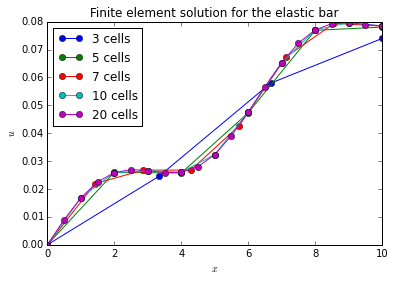

In [21]:
plt.xlabel('$x$')
plt.ylabel('$u$')
plt.title('Finite element solution for the elastic bar')
for u, mesh in solutions:
    plt.plot(mesh, u, 'o-', label=str(len(mesh)-1) + ' cells');
plt.legend(loc='upper left');

We can see that the solutions get closer as the mesh is refined.

**Exercise** Experiment with your own loading function, and compare the computed results to an analytical solution.

In [22]:
def f_sinc(x):
    return np.sin(x)/x

meshes = [3,5,7,10, 20]
solutions = [solver(L, f_sinc, n) for n in meshes]

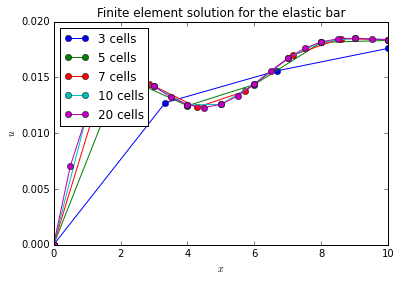

In [23]:
plt.xlabel('$x$')
plt.ylabel('$u$')
plt.title('Finite element solution for the elastic bar')
for u, mesh in solutions:
    plt.plot(mesh, u, 'o-', label=str(len(mesh)-1) + ' cells');
plt.legend(loc='upper left');